In [1]:
import nilearn
from nibabel.testing import data_path
from nilearn import datasets, plotting, regions
import brainspace
import pandas as pd
import numpy as np
import seaborn as sns
import os
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.interfaces.fmriprep import load_confounds_strategy
from brainspace.utils.parcellation import map_to_labels
from nilearn.connectome import ConnectivityMeasure
from nilearn import signal
from brainspace.gradient import GradientMaps


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [75]:
def get_corticalVertices(data):
	""" Get indices of Cortex Data from cifti file """
	cifti=nib.load(data)
	structMap=cifti.header.get_index_map(1)
	brainModels=list(structMap.brain_models)
	LCrtBM=brainModels[0]
	Lcrt_vrts=np.array(LCrtBM.vertex_indices)
	LnumVerts=LCrtBM.surface_number_of_vertices
	
	RCrtBM=brainModels[1]
	Rcrt_vrts=np.array(RCrtBM.vertex_indices)
	RnumVerts=RCrtBM.surface_number_of_vertices
	
	return {'lIDX':Lcrt_vrts,'lnverts':LnumVerts,'rIDX':Rcrt_vrts,'rnverts':RnumVerts}
	

In [26]:
cortex_indices = get_corticalVertices("sub-A00000541/ses-20100101/func/sub-A00000541_ses-20100101_task-rest_space-fsLR_den-91k_bold.dtseries.nii")
#L_cortex_indices = cortex_indices["lIDX"]
#R_cortex_indices = cortex_indices["rIDX"] + 32492
cortex_indices["lIDX"]
cortex_indices["rIDX"].shape

(29696,)

(29716,)

In [ ]:
subj = "A00038624"
anatdir="/Users/VictoriaShevchenko/Documents/PhD/COBRE/fmriprep-sub-A00038624/ses-20130101/anat"
fdir="/Users/VictoriaShevchenko/Documents/PhD/COBRE/fmriprep-sub-A00038624/ses-20130101/func"

Lsrf32="/Users/VictoriaShevchenko/Documents/PhD/HCP/surfaces/tpl-fsLR_den-32k_hemi-L_midthickness.surf.gii"
LsrfNative=f'{anatdir}/sub-A00038624_ses-20130101_acq-mprage_hemi-L_midthickness.surf.gii'

Rsrf32="/Users/VictoriaShevchenko/Documents/PhD/HCP/surfaces/tpl-fsLR_den-32k_hemi-R_midthickness.surf.gii"
RsrfNative=f'{anatdir}/sub-A00038624_ses-20130101_acq-mprage_hemi-R_midthickness.surf.gii'

In [2]:
subj_surf_ts_s1 = nib.load("sub-A00000541/ses-20100101/func/sub-A00000541_ses-20100101_task-rest_space-fsLR_den-91k_bold.dtseries.nii").get_fdata()
subj_surf_ts_s2 = nib.load("sub-A00000541/ses-20110101/func/sub-A00000541_ses-20110101_task-rest_space-fsLR_den-91k_bold.dtseries.nii").get_fdata()

In [3]:
confounds_out_s1 = load_confounds_strategy("sub-A00000541/ses-20100101/func/sub-A00000541_ses-20100101_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz", denoise_strategy = "simple")
confounds_out_s2 = load_confounds_strategy("sub-A00000541/ses-20110101/func/sub-A00000541_ses-20110101_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz", denoise_strategy = "simple")
confounds_out = np.concatenate([confounds_out_s1[0], confounds_out_s2[0]])

In [24]:
all_ts = np.concatenate([subj_surf_ts_s1, subj_surf_ts_s2])
clean_ts = signal.clean(all_ts, confounds = confounds_out)


In [33]:
clean_ts_L = clean_ts[:, :len(cortex_indices["lIDX"])]
clean_ts_R = clean_ts[:, 32492:32492+len(cortex_indices["rIDX"])]

In [72]:
left_data = all_ts[0, :len(cortex_indices["lIDX"])]
#right_data = all_ts[0, 32492:32492+len(cortex_indices["rIDX"])]
#right_data = all_ts[0, 32492+cortex_indices["rIDX"]]
i =len(cortex_indices["lIDX"])
right_data = all_ts[0, len(cortex_indices["lIDX"]):len(cortex_indices["lIDX"])+len(cortex_indices["rIDX"])]
data = np.concatenate([left_data, right_data])

In [57]:
right_data
left_data

array([781.71863056, 794.82285514, 788.90308223, ..., 557.62831793,
       552.5696029 , 557.62831793])

array([798.21327053, 881.19772348, 888.00546232, ..., 759.62711439,
       761.08014956, 763.2058862 ])

In [8]:
nib.load(sulc_lh).darrays[0].data.shape
ldata=nib.load(sulc_lh).darrays[0].data

(32492,)

In [109]:
int(len(cortex_clean_ts)/2)

32492

In [110]:
cortex_clean_ts = hcp.cortex_data(clean_ts[0])
cortex_clean_ts[0:int(len(cortex_clean_ts)/2)]

array([-0.73963176,  0.33201037,  1.1089702 , ...,  1.21083968,
        1.44906289,  1.21897196])

In [114]:
cortex_clean_ts[0:int(len(cortex_clean_ts)/2)]
hcp.left_cortex_data(clean_ts_L[0])

array([-0.73963176,  0.33201037,  1.1089702 , ...,  1.21083968,
        1.44906289,  1.21897196])

(300, 29696)

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_25365/2774403535.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


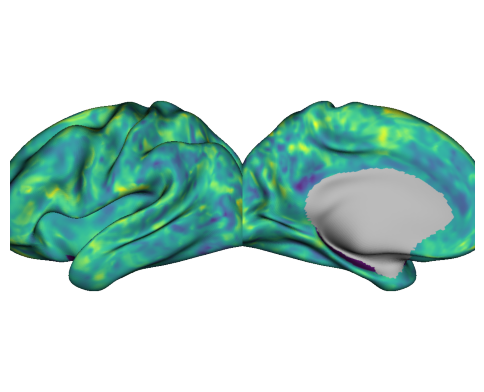

In [116]:
from neuromaps.datasets import fetch_fslr
import hcp_utils as hcp

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']

from surfplot import Plot
sulc_lh, sulc_rh = surfaces['sulc']

p = Plot(surf_lh=lh)
p.add_layer({'left':cortex_clean_ts[0:int(len(cortex_clean_ts)/2)]}, cbar=False)
fig = p.build()
# show figure, as you typically would with matplotlib
fig.show()

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_25365/1963593704.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


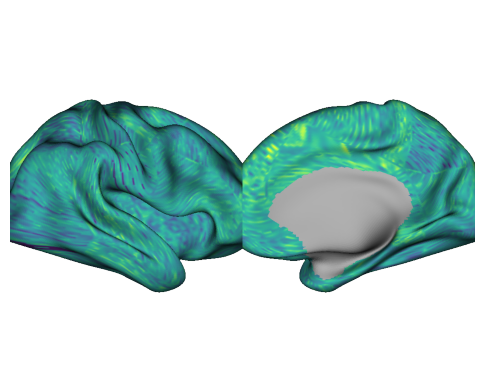

In [117]:
p = Plot(surf_rh=rh)
p.add_layer({'right': hcp.left_cortex_data(clean_ts_R[0])}, cbar=False)
fig = p.build()
# show figure, as you typically would with matplotlib
fig.show()



In [19]:
import hcp_utils as hcp

hcp.vertex_info
hcp.left_cortex_data(subj_surf_ts_s1[0, :29696]).shape


{'grayl': array([    0,     1,     2, ..., 32489, 32490, 32491]),
 'grayr': array([    0,     1,     2, ..., 32489, 32490, 32491]),
 'num_meshl': 32492,
 'num_meshr': 32492}

(32492,)

In [35]:
clean_ts_L.shape

(300, 29696)

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_25365/2217638373.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


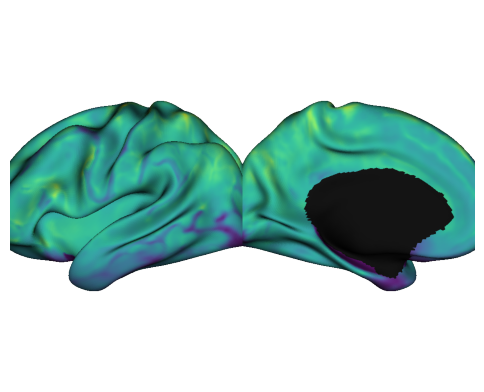

In [45]:
p = Plot(surf_lh=lh)
p.add_layer({'left':hcp.left_cortex_data(left_data)}, cbar=False)
fig = p.build()
# show figure, as you typically would with matplotlib
fig.show()

/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


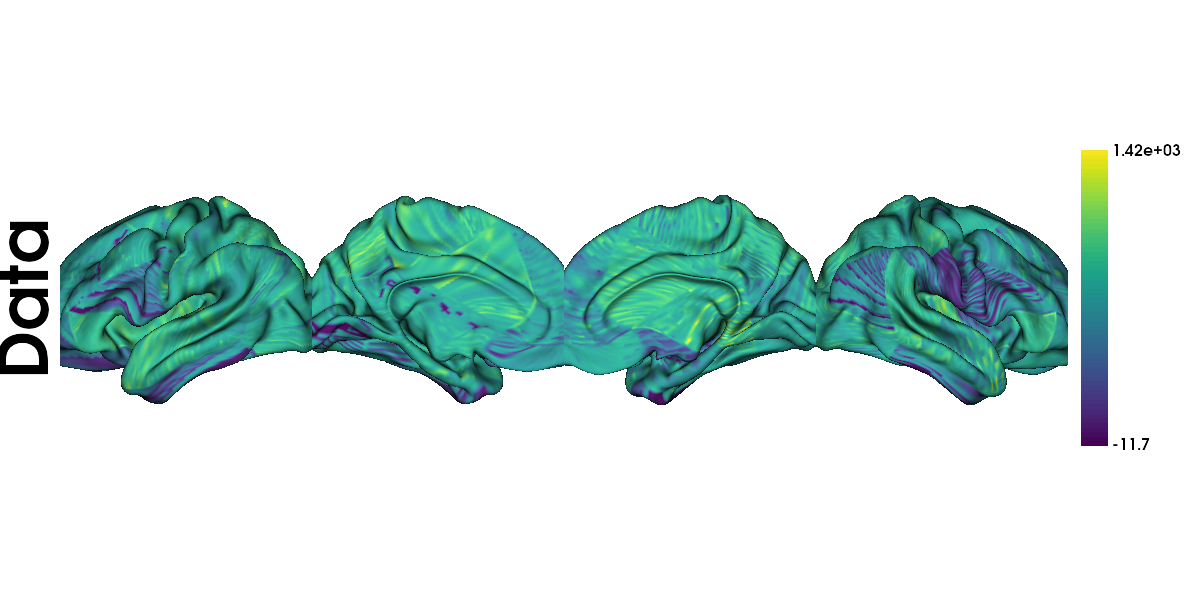

In [239]:
plot_hemispheres(surf_lh, surf_rh, array_name=data, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Data'], zoom=1.5, embed_nb = True)

In [227]:
clean_ts = signal.clean(all_ts, confounds = confounds_out)


In [222]:
cortex_indices = get_corticalVertices("sub-A00000541/ses-20100101/func/sub-A00000541_ses-20100101_task-rest_space-fsLR_den-91k_bold.dtseries.nii")
L_cortex_indices = cortex_indices["lIDX"]
R_cortex_indices = cortex_indices["rIDX"] + 32492

In [232]:
get_corticalVertices("sub-A00000541/ses-20100101/func/sub-A00000541_ses-20100101_task-rest_space-fsLR_den-91k_bold.dtseries.nii")[]



{'lIDX': array([    0,     1,     2, ..., 32489, 32490, 32491]),
 'lnverts': 32492,
 'rIDX': array([    0,     1,     2, ..., 32489, 32490, 32491]),
 'rnverts': 32492}

In [31]:
correlation_measure = np.corrcoef(clean_ts.T)

(59412,)

In [80]:
lab_l = nib.load('/Users/VictoriaShevchenko/Documents/PhD/HCP/labels/fsLR.32k.L.label.gii').agg_data()
lab_r = nib.load('/Users/VictoriaShevchenko/Documents/PhD/HCP/labels/fsLR.32k.R.label.gii').agg_data()
labs  = np.concatenate((lab_l, lab_r))
cortical_labels = labs[labs != 0]

In [207]:
lab_l
lab_r


array([7, 7, 1, ..., 5, 5, 5], dtype=int32)

array([7, 7, 6, ..., 2, 2, 2], dtype=int32)

In [213]:
labs[labs != 0].shape

(59412,)

In [7]:
gm = GradientMaps(n_components=3, approach='dm', kernel='pearson', alignment = "procrustes")
#gm = GradientMaps(approach='dm', kernel='pearson', alignment = "procrustes")
gm.fit(correlation_matrix)


grad = [None] * 3
for i, g in enumerate(gm.gradients_.T):
    grad[i] = map_to_labels(g, labs[labs != 0])

In [94]:
cobre_subject_grad = np.load("grads_A00038624_pearson.npy")

In [95]:
cobre_subject_grad_labeled = np.array([hcp.cortex_data(i) for i in cobre_subject_grad])
cobre_subject_grad_labeled.shape

(3, 64984)

In [192]:
cobre_subject_grad.shape


(3, 59412)

In [118]:
lab_l = nib.load('/Users/VictoriaShevchenko/Documents/PhD/HCP/labels/fsLR.32k.L.label.gii').agg_data()
lab_r = nib.load('/Users/VictoriaShevchenko/Documents/PhD/HCP/labels/fsLR.32k.R.label.gii').agg_data()
labs  = np.concatenate((lab_l, lab_r))

#labs = labs.astype(float)
#labs[labs == 0] = np.nan
#cortical_indices = np.where(np.isnan(labs) != True)[0]

In [165]:
cortex_indices.shape


(59412,)

In [81]:
grads = [None] * 3
for i, g in enumerate(cobre_subject_grad):
    grads[i] = map_to_labels(g, labs[labs != 0])



In [77]:
grads_labeled = np.empty((3, 32492*2))
for index, grad in enumerate(grads_labeled):
    grad[labs != 0] = grads[index]

NameError: name 'grads' is not defined

In [83]:
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
surf_lh, surf_rh = load_conte69()

In [162]:
array = nib.load("sub-A00000541/ses-20100101/func/sub-A00000541_ses-20100101_task-rest_space-fsnative_hemi-L_bold.func.gii")

In [164]:
array.agg_data().shape

(97069, 150)

<AxesSubplot: >

Text(0.5, 0, 'Grad 2')

Text(0, 0.5, 'Grad 3')

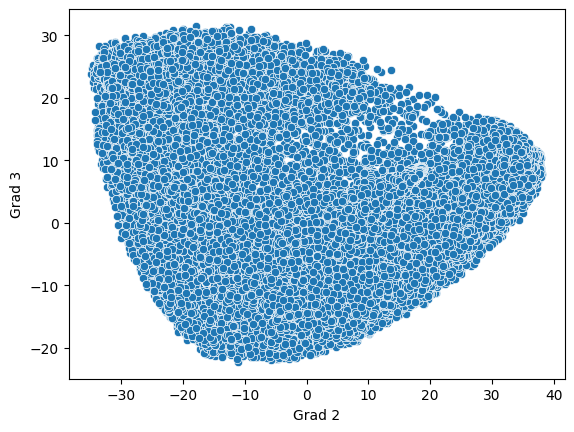

In [87]:
sns.scatterplot(x = cobre_subject_grad[1],y = cobre_subject_grad[2])
plt.xlabel("Grad 2")
plt.ylabel("Grad 3")

In [233]:
left_data = clean_ts[0, :32492]
right_data = clean_ts[0, 32492:2*32492]
data = np.concatenate([left_data, right_data])

/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


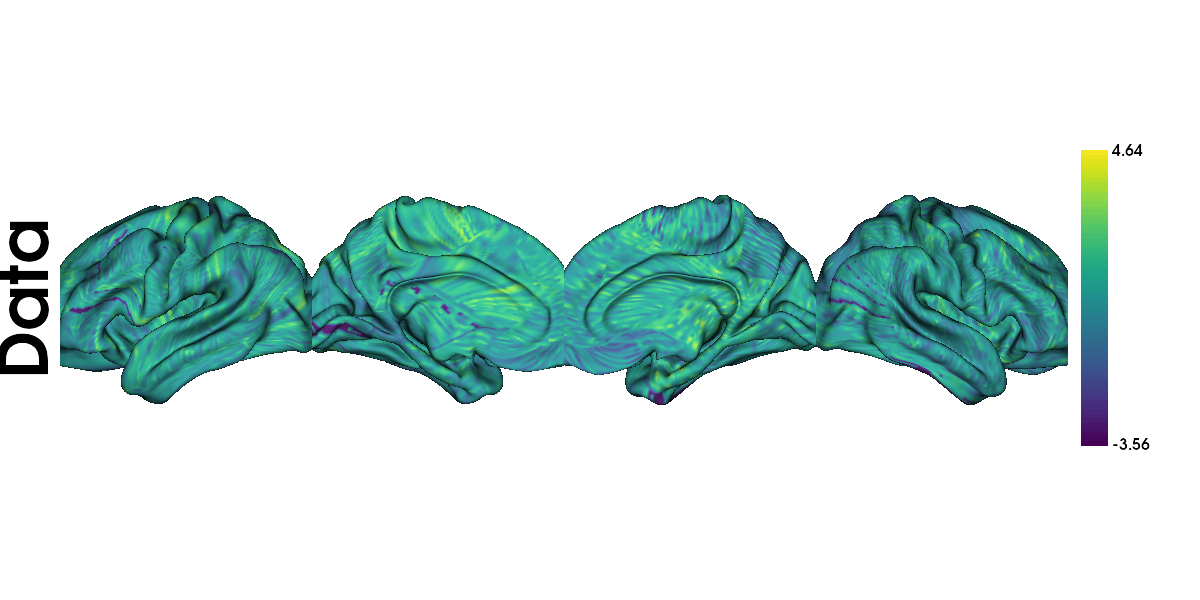

In [234]:
plot_hemispheres(surf_lh, surf_rh, array_name=data, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Data'], zoom=1.5, embed_nb = True)

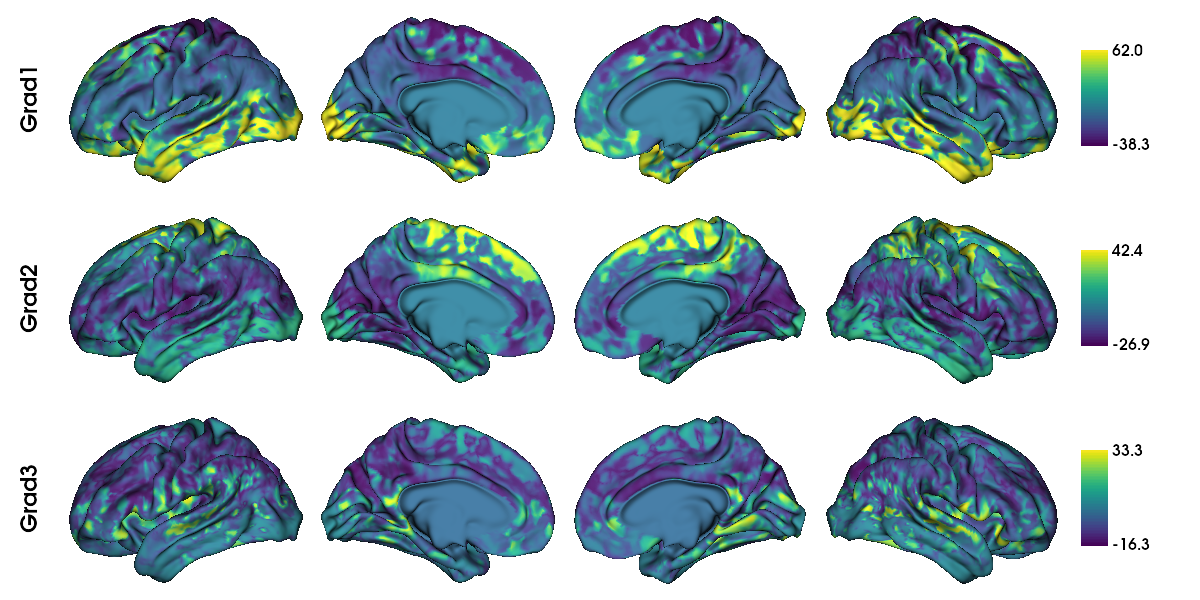

In [96]:
plot_hemispheres(surf_lh, surf_rh, array_name=cobre_subject_grad_labeled, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.5, embed_nb = True)


In [ ]:
plot_hemispheres(surf_lh, surf_rh, array_name=grad_control, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.5, embed_nb = True)

In [14]:
grad_control_df = pd.DataFrame(np.array(grad_control).T, columns = ["Grad 1", "Grad 2", "Grad 3"])
#grad_control_df["Network"] = network_labels
grad_mdd_df = pd.DataFrame(np.array(grad_mdd).T, columns = ["Grad 1", "Grad 2", "Grad 3"])
#grad_mdd_df["Network"] = network_labels


In [15]:
grad_control_df

,Grad 1,Grad 2,Grad 3
0,1.181922,0.402953,-0.660669
1,-1.335934,-0.224254,0.883634
2,-1.007951,-0.164312,0.412713
3,1.220200,-0.492197,0.220665
4,-0.315390,1.994808,0.202142
...,...,...,...
64979,1.218336,-0.398989,1.160219
64980,0.970074,-0.480798,-0.054768
64981,0.393939,-0.041510,-1.017653
64982,0.393939,-0.041510,-1.017653


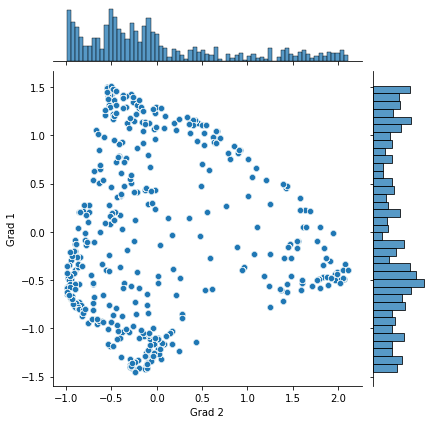

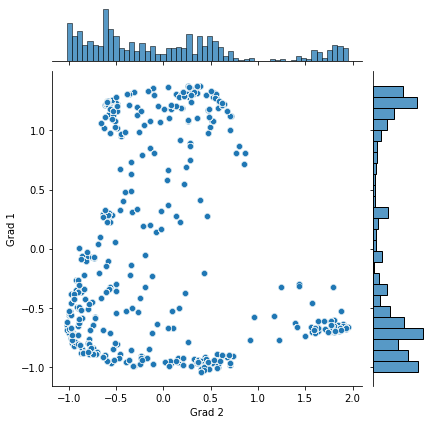

In [15]:

sns.jointplot(data = grad_control_df, x = "Grad 2", y = "Grad 1") #, hue = "Grad 1", palette = "viridis"
sns.jointplot(data = grad_mdd_df, x = "Grad 2", y = "Grad 1") #, hue = "Grad 1", palette = "viridis"


In [ ]:
yeo_atlas = nilearn.datasets.fetch_atlas_yeo_2011()

In [ ]:
import nibabel
yeo_atlas  = nibabel.load("/Users/VictoriaShevchenko/Documents/PhD/yeo_parc/CIFTI2-RSN-networks.32k_fs_LR.dlabel.nii")


<AxesSubplot:xlabel='Grad 3', ylabel='Grad 1'>

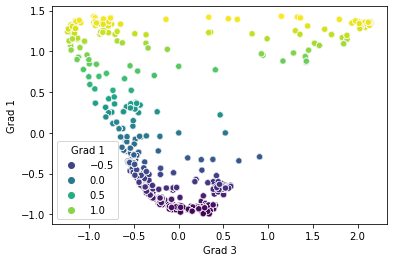

In [43]:
sns.scatterplot(x = grad_mdd_df["Grad 2"], y = grad_mdd_df["Grad 1"])



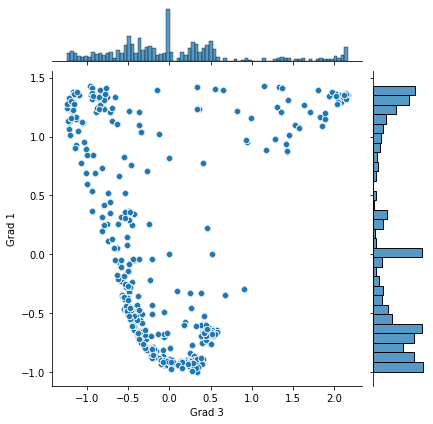

In [44]:
sns.jointplot(x = grad_mdd_df["Grad 3"], y = grad_mdd_df["Grad 1"])


Generating random data for visualization

In [19]:
N = 1000
variance_explained_hc = np.random.normal(0.20, 0.05, N)
variance_explained_mdd = np.random.normal(0.195, 0.05, N)
variance_explained_ocd = np.random.normal(0.178, 0.05, N)
variance_explained_bd = np.random.normal(0.169, 0.05, N)
variance_explained_scz = np.random.normal(0.155, 0.05, N)
variance_explained_autism = np.random.normal(0.12, 0.05, N)

variance_explained = np.concatenate((variance_explained_hc, variance_explained_mdd, variance_explained_ocd, variance_explained_bd, variance_explained_scz, variance_explained_autism))



In [9]:
hc_labels = np.empty([1, N], dtype='U25')
mdd_labels = np.empty([1, N], dtype='U25')
ocd_labels = np.empty([1, N], dtype='U25')
bd_labels = np.empty([1, N], dtype='U25')
scz_labels = np.empty([1, N], dtype='U25')
autism_labels = np.empty([1, N], dtype='U25')
hc_labels[:] = "HC"
mdd_labels[:] = "MDD"
ocd_labels[:] = "OCD"
bd_labels[:] = "BD"
scz_labels[:] = "SCZ"
autism_labels[:] = "Autism"

group_labels = np.concatenate((hc_labels, mdd_labels, ocd_labels, bd_labels, scz_labels, autism_labels))
group_labels = group_labels.flatten()

In [25]:
df_fake = pd.DataFrame({"% Var Explained, Principal Gradient" : variance_explained, "Group":group_labels})
df_fake

,"% Var Explained, Principal Gradient",Group
0,0.183269,HC
1,0.242254,HC
2,0.208159,HC
3,0.193339,HC
4,0.141195,HC
...,...,...
5995,0.061604,Autism
5996,0.052345,Autism
5997,0.142294,Autism
5998,0.155478,Autism


In [20]:
hyp_plot = sns.violinplot(x = df_fake["Group"], y = df_fake["% Var Explained, Principal Gradient"])
hyp_plot.axhline(0.2, color = "black", linestyle = "--")
plt.show()

NameError: name 'df_fake' is not defined

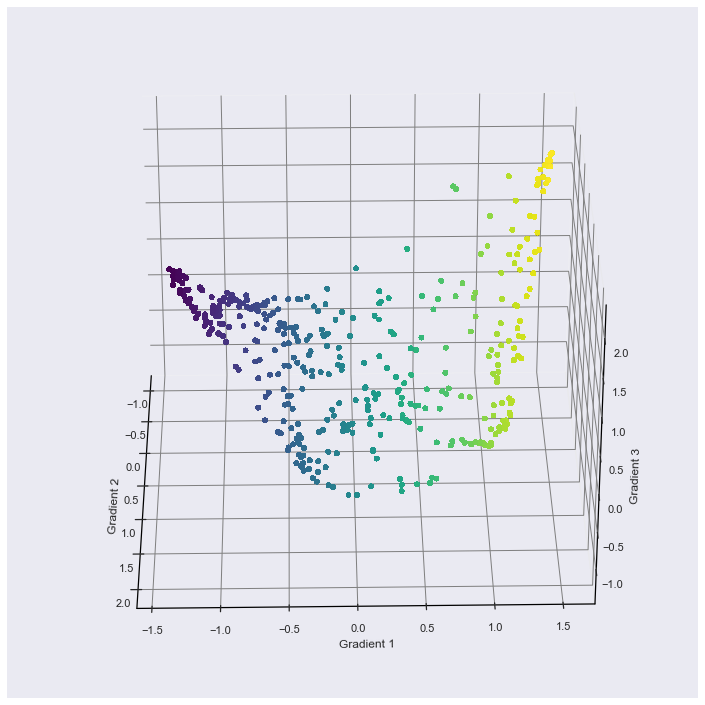

In [93]:
%matplotlib inline

import mpl_toolkits
from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = 12.8, 9.6

fig = plt.figure()
ax = Axes3D(fig)

def init():
   ax.scatter(grad_control_df["Grad 2"], grad_control_df["Grad 1"], grad_control_df["Grad 3"], cmap='viridis', linewidth=0.5, c = grad_control_df["Grad 1"])
   ax.xaxis.pane.fill = False
   ax.yaxis.pane.fill = False
   ax.zaxis.pane.fill = False
   ax.w_xaxis.line.set_color("black")
   ax.w_yaxis.line.set_color("black")
   ax.w_zaxis.line.set_color("black")
   ax.xaxis._axinfo["grid"]['color'] =  ("grey")
   ax.yaxis._axinfo["grid"]['color'] =  ("grey")
   ax.zaxis._axinfo["grid"]['color'] =  ("grey")
   ax.set_xlabel('Gradient 2')
   ax.set_ylabel('Gradient 1')
   ax.set_zlabel('Gradient 3')
   return fig,

def animate(i):
    ax.view_init(elev=30., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
writergif = animation.PillowWriter(fps=30)                       
# Save
anim.save('3Dgradient.gif', writer=writergif)

Text(0.5, 0, 'Gradient 2')

Text(0.5, 0, 'Gradient 1')

Text(0.5, 0, 'Gradient 3')

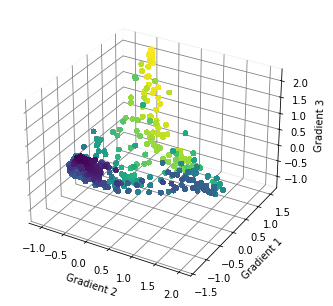

In [16]:

from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

fig = plt.figure()
ax = Axes3D(fig)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.w_xaxis.line.set_color("black")
ax.w_yaxis.line.set_color("black")
ax.w_zaxis.line.set_color("black")

ax.xaxis._axinfo["grid"]['color'] =  ("grey")
ax.yaxis._axinfo["grid"]['color'] =  ("grey")
ax.zaxis._axinfo["grid"]['color'] =  ("grey")

#cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

gradient_3d = ax.scatter(grad_control_df["Grad 2"], grad_control_df["Grad 1"], grad_control_df["Grad 3"], cmap='viridis', linewidth=0.5, c = grad_control_df["Grad 1"], alpha = 1)

# Get rid of the panes                          

ax.set_xlabel('Gradient 2')
ax.set_ylabel('Gradient 1')
ax.set_zlabel('Gradient 3')

# legend
#plt.legend(*gradient_3d.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

In [16]:
grad_mdd_df["Group"] = "MDD"
grad_control_df["Group"] = "HC"
gradients = pd.concat([grad_mdd_df, grad_control_df])

In [1]:
len(grad_control_df)


KeyboardInterrupt



In [17]:
gradients.reset_index(level=0, inplace=True)
gradients = gradients.loc[:, gradients.columns != "index"]

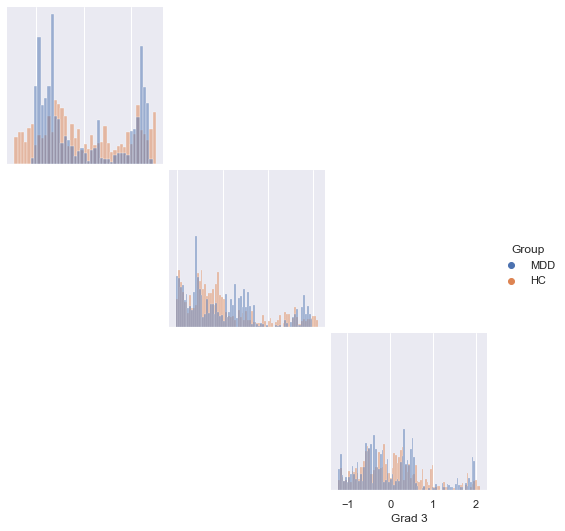

In [18]:
sns.set(rc={'figure.facecolor':'white'})
import matplotlib.pyplot as plt
g = sns.pairplot(gradients, hue = "Group", diag_kind="hist", corner = True)
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g.map_upper(hide_current_axis)
g.map_lower(hide_current_axis)

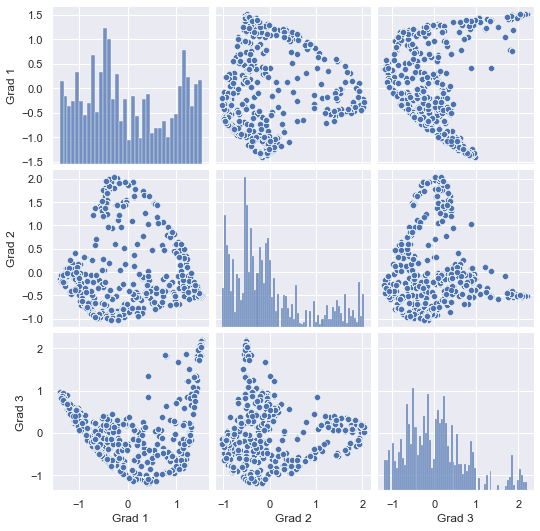

In [37]:
sns.pairplot(grad_control_df)

In [19]:
import math
vertex_density_1grad = []
for score in grad_control[0]:
    distance = []
    for index_shift in [-3, -2, -1, 1, 2, 3]:
        if math.isnan(score) == True:
            distance.append(np.nan)
        else:
            next_score = grad_control[0][list(grad_control[0]).index(score) + index_shift]
            if np.isnan(next_score) == True:
                next_score = 0
            distance.append(abs(score - next_score))
    distance = np.sum(distance)/len(distance)
    vertex_density_1grad.append(distance)

In [22]:
vertex_density_1grad_mdd = []
for score in grad_mdd[0]:
    distance = []
    for index_shift in [-3, -2, -1, 1, 2, 3]:
        if math.isnan(score) == True:
            distance.append(np.nan)
        else:
            next_score = grad_mdd[0][list(grad_mdd[0]).index(score) + index_shift]
            if np.isnan(next_score) == True:
                next_score = 0
            distance.append(abs(score - next_score))
    distance = np.sum(distance)/len(distance)
    vertex_density_1grad_mdd.append(distance)

In [20]:
vertex_density_control = np.empty((3, 64984))
vertex_density_control[:] = np.nan
vertex_density_control[0] = vertex_density_1grad

In [26]:
vertex_density_mdd = np.empty((3, 64984))
vertex_density_mdd[:] = np.nan
vertex_density_mdd[0] = vertex_density_1grad_mdd

/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/utils.py:303: RuntimeWarning: All-NaN axis encountered
  a, b = np.nanmin(x), np.nanmax(x)
/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/utils.py:367: RuntimeWarning: All-NaN slice encountered
  specs['min'][:] = np.nanmin(specs['min'], axis=ax, keepdims=True)
/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/utils.py:368: RuntimeWarning: All-NaN slice encountered
  specs['max'][:] = np.nanmax(specs['max'], axis=ax, keepdims=True)
/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


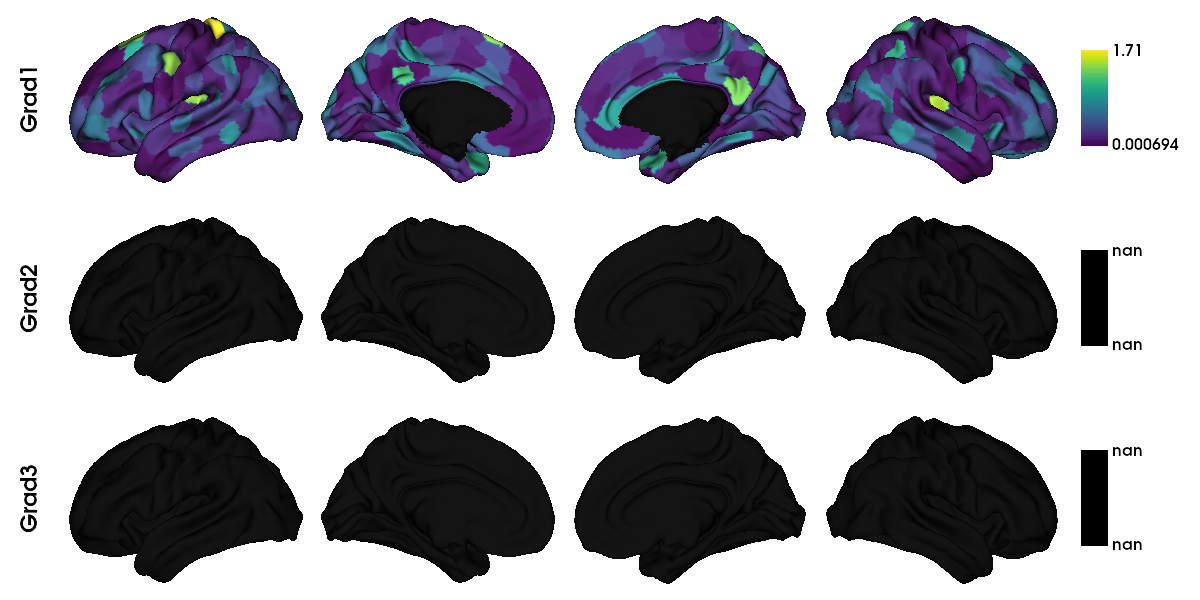

In [21]:
plot_hemispheres(surf_lh, surf_rh, array_name=vertex_density_control, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.5, embed_nb = True)

/Users/VictoriaShevchenko/opt/anaconda3/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


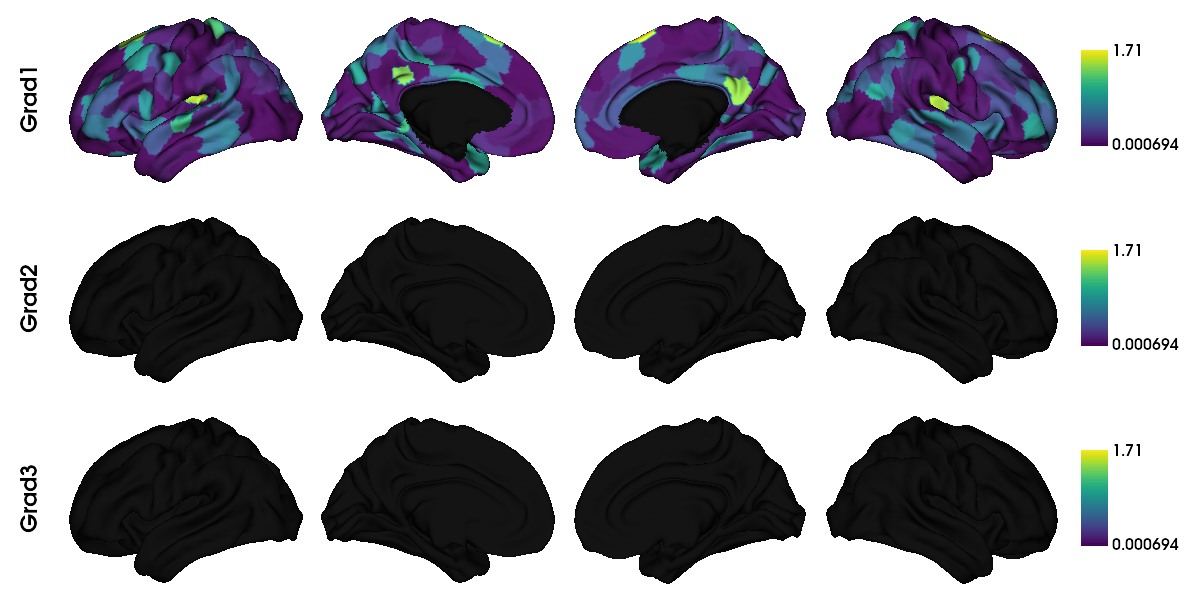

In [29]:
plot_hemispheres(surf_lh, surf_rh, array_name=vertex_density_mdd, size=(1200, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.5, embed_nb = True, color_range= (0.000694, 1.71))

In [102]:
len(vertex_density_1grad)
len(grad_control[0])

50658

64984

In [98]:
grad_control[0][7]
1.5 - grad_control[0][list(grad_control[0]).index(0.878203770556897) + 3]
list(grad_control[0]).index(1.080553189020806) + 1

nan

0.621796229443103

72

In [92]:
list(grad_control[0]).index(score).isnan

0.878203770556897

list

[0.419446810979194]

list